In [52]:
import player_data_setup as setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [53]:

player_name = "shai_gilgeous-alexander"
player_team = "OKC"
opponent = "LAL"
change = "" # if you made a big model change, what was it?
player_df = setup.player_data_merge(f"./data/player_game_data/{player_team}/{player_name}.csv")
team_stats_df = pd.read_csv("./data/team_def_stats.csv")


In [54]:
player_df = setup.get_rolling_avgs(player_df)

In [55]:
print(player_df.columns) # for reference!

Index(['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%_x', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Home', 'DRtg', 'Pace', 'eFG%_y', 'TOV%', 'DRB%',
       'FT/FGA', 'PTS_last_5_avg', 'FGA_last_5_avg', 'MP_last_5_avg',
       'Opp_DRtg_x_PTS', 'Opp_Pace_x_FGA', 'Opp_eFG_x_PTS', 'PTS_5_game_trend',
       'PTS_volatility_5', 'Hot_Streak', 'PTS_per_minute', 'PTS_pct_of_max'],
      dtype='object')


In [56]:
scaler = StandardScaler()
columns_to_scale = [ 'DRtg', "Pace", "TOV%", "DRB%",
    'PTS_last_5_avg', 'FGA_last_5_avg', 'MP_last_5_avg',
        'Opp_DRtg_x_PTS', 'Opp_Pace_x_FGA', 'Opp_eFG_x_PTS', 'PTS_5_game_trend',
        'PTS_volatility_5',
        'Hot_Streak',
        
        'PTS_per_minute',
        'PTS_pct_of_max',
]
exiled = ['MP_x_FGA',] # stats that were unhelpful or overfitting
player_df[columns_to_scale] = scaler.fit_transform(player_df[columns_to_scale])

Random Forest Regression Model

In [57]:
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)


XGBoost Model

In [58]:

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,           
    learning_rate=0.05,           
    max_depth=8,                
    subsample=0.8,                
    colsample_bytree=0.8,          
    seed=42                       
)

Stacked Model

In [59]:
estimators = [
    ('rf', rfr_model),
    ('xgb', xgb_model)
]
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

Here's our splits

In [60]:
X, X_test, X_train, y_train, y_test = setup.get_splits(player_df)

And finally we fit the models.

In [61]:
rfr_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
stacked_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

In [62]:

rfr_y_pred = rfr_model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)
stacked_y_pred = stacked_model.predict(X_test)

rfr_mae = mean_absolute_error(y_test, rfr_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
stacked_mae = mean_absolute_error(y_test, stacked_y_pred)

rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_y_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
stacked_rmse = mean_squared_error(y_test, stacked_y_pred)

print(f"Mean Absolute Error (MAE): Random Forest : {rfr_mae:.2f}")
print(f"Mean Absolute Error (MAE): XGBoost : {xgb_mae:.2f}")
print(f"Mean Absolute Error (MAE): Stacked : {stacked_mae:.2f}")
print()
print(f"Root Mean Squared Error (RMSE):  Random Forest : {rfr_rmse:.2f}")
print(f"Root Mean Squared Error (RMSE): XGBoost : {xgb_rmse:.2f}")
print(f"Root Mean Squared Error  (RMSE): Stacked : {stacked_rmse:.2f}")


Mean Absolute Error (MAE): Random Forest : 3.10
Mean Absolute Error (MAE): XGBoost : 3.97
Mean Absolute Error (MAE): Stacked : 2.83

Root Mean Squared Error (RMSE):  Random Forest : 3.91
Root Mean Squared Error (RMSE): XGBoost : 4.91
Root Mean Squared Error  (RMSE): Stacked : 11.79


Here's a plot of feature importance from XGBoost. Helpful, but I've also noticed it varies by player.

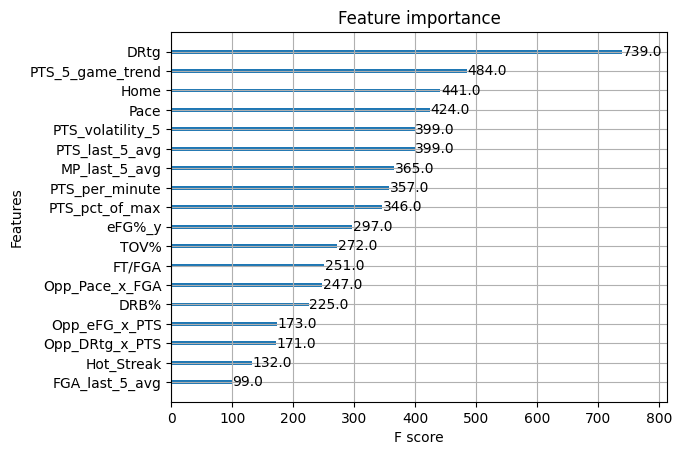

In [63]:
xgb.plot_importance(xgb_model, importance_type="weight")
plt.show()

NOW:

It's time to predict a specific game. You entered the opponent and all necessary information at the top. So, just let it run!

In [64]:
# put in opponent, player_df, and team_stats_df to prep the game stats. this makes for minimal need for manual data adjustment
input_game = setup.prep_game(opponent, player_df, team_stats_df)

In [65]:
input_game # for viewing. I recommend installing the Data Wrangler extension- it allows for easier viewing of dfs when typed like this

,Home,DRtg,Pace,eFG%_y,TOV%,DRB%,FT/FGA,PTS_last_5_avg,FGA_last_5_avg,MP_last_5_avg,Opp_DRtg_x_PTS,Opp_Pace_x_FGA,Opp_eFG_x_PTS,PTS_5_game_trend,PTS_volatility_5,Hot_Streak,PTS_per_minute,PTS_pct_of_max
0,0,114.6,97.6,0.539,12.1,74.9,0.18,29.909091,29.909091,32.659091,3427.581818,2919.127273,16.121,-5.0,4.253341,1.0,0.854326,0.702703


Here's the predicted points scored based on each model, with the MAE of each model as a reminder.

In [66]:
predicted_pts_rfg = setup.predict_game(input_game, scaler,columns_to_scale, rfr_model,X)
predicted_pts_xgb= setup.predict_game(input_game, scaler,columns_to_scale, xgb_model,X)
predicted_pts_stacked = setup.predict_game(input_game, scaler, columns_to_scale, stacked_model,X)
print(f"Predicted Points Random Forest: {predicted_pts_rfg:>6.1f}")
print(f"Predicted Points XGBoost: {predicted_pts_xgb:>12.1f}")
print(f"Predicted Points Stacked: {predicted_pts_stacked:>12.1f}")
print(f"MAE Random Forest : {rfr_mae:>10.2f}")
print(f"MAE XGBoost: {xgb_mae:>17.2f}")
print(f"MAE Stacked: {stacked_mae:>17.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Predicted Points Random Forest:   39.2
Predicted Points XGBoost:         36.4
Predicted Points Stacked:         40.0
MAE Random Forest :       3.10
MAE XGBoost:              3.97
MAE Stacked:              2.83


In [67]:
data = {
    
    "Player" : [player_name],
    "Opponent": [opponent],
    "XGB" : [f"xbg: {predicted_pts_xgb:.2f}"],
    "RFG" : [f"rfg: {predicted_pts_rfg}"],
    "Stacked" : [f"stacked: {predicted_pts_stacked:.2f}"],
    "Change Made": [change]
    
}
df = pd.DataFrame(data)
# this next line writes a line to the csv file for documentation purposes.
# i have it commented out for now.
df.to_csv('./data/predictions.csv', mode='a', header=False, index=False)